# Algorithm Performance

## Setup

In [1]:
from importlib import import_module
import json

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import bookgender.datatools as dt
from bookgender.config import data_dir

## Load Performance Data

We need to collect all of the accuracy output files.

In [4]:
perf_data = pd.read_csv('data/rec-perf.csv')
perf_data

,MRR,HR,NDCG,DataSet,Algorithm
0,0.000760,0.0048,0.001601,BX-E,user-user
1,0.000547,0.0068,0.001694,BX-E,item-item
2,0.002636,0.0314,0.008126,BX-E,als
3,0.025843,0.1584,0.054805,BX-I,user-user
4,0.019148,0.0900,0.034717,BX-I,item-item
5,0.029206,0.1552,0.056242,BX-I,wrls
6,0.015749,0.1036,0.033990,BX-I,bpr
7,0.000333,0.0008,0.000482,AZ,user-user
8,0.002507,0.0272,0.007296,AZ,item-item
9,0.000474,0.0038,0.001138,AZ,als


In [5]:
tune_data = pd.read_json('data/rec-tune.json', orient='records', lines=True)
tune_data

,params,iters,MRR,DataSet,Algorithm
0,"[67, 0.069343245462767]",20,0.000856,BX-E,user-user
1,"[232, 0.084880046234972]",20,0.000540,BX-E,item-item
2,"[297, 4.36979166769093, 4.927362178355647, 24....",20,0.002965,BX-E,als
3,"[303, 0.052267596581313004]",20,0.026312,BX-I,user-user
4,"[61, 0.03579462837616]",20,0.015321,BX-I,item-item
5,"[499, 0.151451427679924, 0.06685861681803601, ...",20,0.026321,BX-I,wrls
6,"[249, 0.011980259542217, 0.09697898418796101]",20,0.014692,BX-I,bpr
7,"[68, 0.070821028781701]",20,0.000306,AZ,user-user
8,"[5, 0.1]",20,0.002919,AZ,item-item
9,"[299, 0.027209462059128, 0.09593544705902601, ...",100,0.000533,AZ,als


In [6]:
rerank_data = pd.read_csv('data/rerank-perf.csv')
rerank_data

,Strategy,MRR,HR,NDCG,DataSet,Algorithm
0,SingleEQ,0.000731,0.0038,0.001415,BX-E,user-user
1,GreedyEQ,0.000714,0.0040,0.001422,BX-E,user-user
2,GreedyReflect,0.000713,0.0040,0.001423,BX-E,user-user
3,SingleEQ,0.000461,0.0066,0.001540,BX-E,item-item
4,GreedyEQ,0.000483,0.0064,0.001551,BX-E,item-item
5,GreedyReflect,0.000491,0.0072,0.001684,BX-E,item-item
6,SingleEQ,0.002449,0.0248,0.006868,BX-E,als
7,GreedyEQ,0.002606,0.0324,0.008196,BX-E,als
8,GreedyReflect,0.002660,0.0316,0.008201,BX-E,als
9,SingleEQ,0.021860,0.1156,0.042435,BX-I,user-user


## Organize Runs

We have data sets, and we have implicit/explicit configurations.  For some data sets, these are encoded in the data set; for others, in the algorithm.

We need to split that out.

In [7]:
def normalize_runs(frame):
    frame = frame.assign(Implicit = frame['DataSet'].str.endswith('-I') | frame['Algorithm'].str.endswith('-imp'))
    frame['Algorithm'] = frame['Algorithm'].str.replace('-imp', '')
    frame['DataSet'] = frame['DataSet'].str.replace('-[IE]', '')
    frame['Algorithm'] = frame['Algorithm'].str.replace('wrls', 'als').str.upper()
    frame['Algorithm'] = frame['Algorithm'].str.replace(r'(\w)\w+-(\w)\w+', r'\1\2')
    return frame

In [8]:
perf_data = normalize_runs(perf_data)

And look at that data:

In [9]:
perf_data

,MRR,HR,NDCG,DataSet,Algorithm,Implicit
0,0.000760,0.0048,0.001601,BX,UU,False
1,0.000547,0.0068,0.001694,BX,II,False
2,0.002636,0.0314,0.008126,BX,ALS,False
3,0.025843,0.1584,0.054805,BX,UU,True
4,0.019148,0.0900,0.034717,BX,II,True
5,0.029206,0.1552,0.056242,BX,ALS,True
6,0.015749,0.1036,0.033990,BX,BPR,True
7,0.000333,0.0008,0.000482,AZ,UU,False
8,0.002507,0.0272,0.007296,AZ,II,False
9,0.000474,0.0038,0.001138,AZ,ALS,False


In [10]:
tune_data = normalize_runs(tune_data)
tune_data

,params,iters,MRR,DataSet,Algorithm,Implicit
0,"[67, 0.069343245462767]",20,0.000856,BX,UU,False
1,"[232, 0.084880046234972]",20,0.000540,BX,II,False
2,"[297, 4.36979166769093, 4.927362178355647, 24....",20,0.002965,BX,ALS,False
3,"[303, 0.052267596581313004]",20,0.026312,BX,UU,True
4,"[61, 0.03579462837616]",20,0.015321,BX,II,True
5,"[499, 0.151451427679924, 0.06685861681803601, ...",20,0.026321,BX,ALS,True
6,"[249, 0.011980259542217, 0.09697898418796101]",20,0.014692,BX,BPR,True
7,"[68, 0.070821028781701]",20,0.000306,AZ,UU,False
8,"[5, 0.1]",20,0.002919,AZ,II,False
9,"[299, 0.027209462059128, 0.09593544705902601, ...",100,0.000533,AZ,ALS,False


## Accuracy Plots

Plot the MRR for each data set!

In [11]:
merged_mrr = pd.concat([
    tune_data[['DataSet', 'Algorithm', 'Implicit', 'MRR']].assign(Stage='Tune'),
    perf_data[['DataSet', 'Algorithm', 'Implicit', 'MRR']].assign(Stage='Eval')
], ignore_index=True)

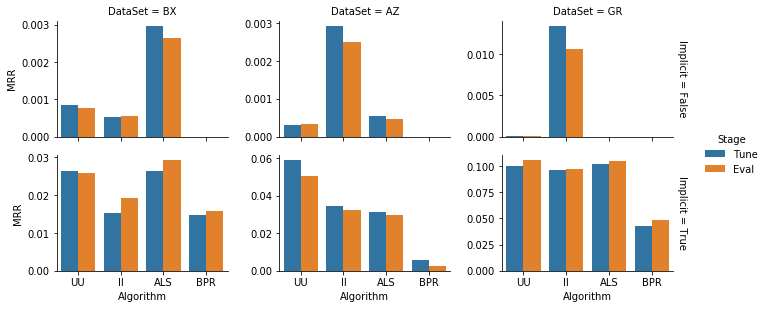

In [12]:
sns.catplot(x='Algorithm', y='MRR', row='Implicit', col='DataSet', hue='Stage', data=merged_mrr, kind='bar',
            sharey=False, margin_titles=True, aspect=1.5, height=2.2)
plt.savefig('figures/rec-perf.pdf')

In [13]:
print(perf_data[['DataSet', 'Algorithm', 'Implicit', 'MRR']].set_index(['DataSet', 'Implicit', 'Algorithm']).unstack().to_latex())

\begin{tabular}{llrrrr}
\toprule
   & {} & \multicolumn{4}{l}{MRR} \\
   & Algorithm &       ALS &       BPR &        II &        UU \\
DataSet & Implicit &           &           &           &           \\
\midrule
AZ & False &  0.000474 &       NaN &  0.002507 &  0.000333 \\
   & True  &  0.029904 &  0.002615 &  0.032598 &  0.050321 \\
BX & False &  0.002636 &       NaN &  0.000547 &  0.000760 \\
   & True  &  0.029206 &  0.015749 &  0.019148 &  0.025843 \\
GR & False &       NaN &       NaN &  0.010657 &  0.000066 \\
   & True  &  0.105331 &  0.048478 &  0.096841 &  0.105628 \\
\bottomrule
\end{tabular}



And hit rate:

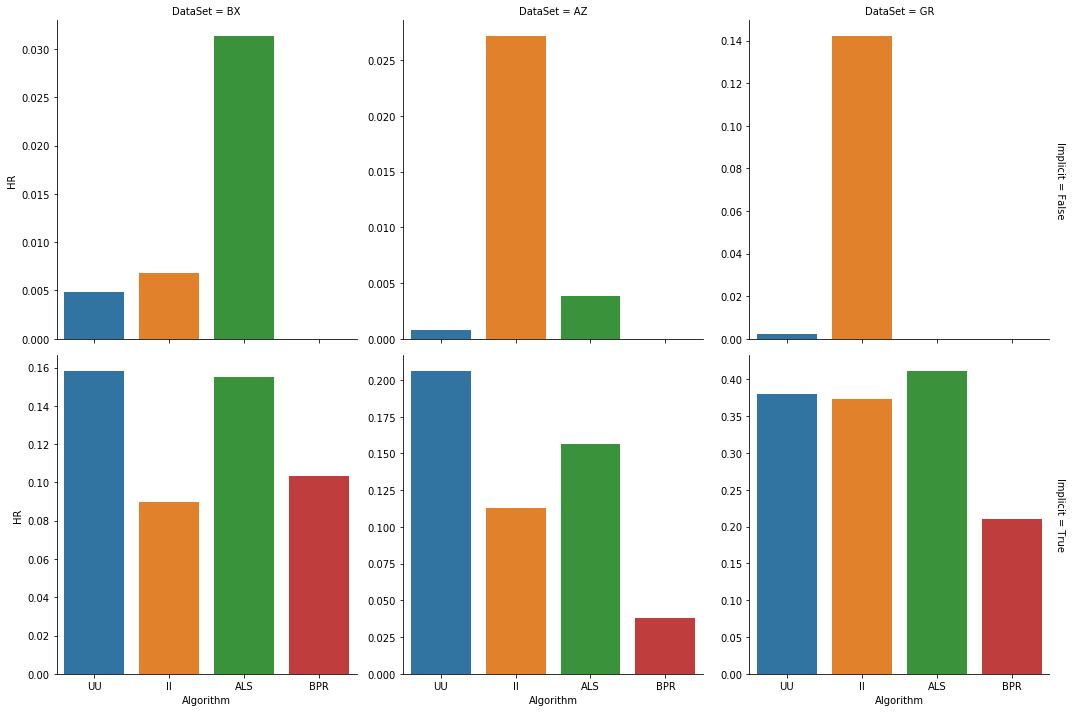

In [14]:
sns.catplot(x='Algorithm', y='HR', row='Implicit', col='DataSet', data=perf_data, kind='bar', 
            sharey=False, margin_titles=True)

## Rerank Loss

In [15]:
rerank_data = normalize_runs(rerank_data)
rerank_data.head()

,Strategy,MRR,HR,NDCG,DataSet,Algorithm,Implicit
0,SingleEQ,0.000731,0.0038,0.001415,BX,UU,False
1,GreedyEQ,0.000714,0.0040,0.001422,BX,UU,False
2,GreedyReflect,0.000713,0.0040,0.001423,BX,UU,False
3,SingleEQ,0.000461,0.0066,0.001540,BX,II,False
4,GreedyEQ,0.000483,0.0064,0.001551,BX,II,False


In [16]:
rr_mrr = pd.concat([
    perf_data[['DataSet', 'Algorithm', 'Implicit', 'MRR', 'HR']].assign(Strategy='Raw'),
    rerank_data[['DataSet', 'Algorithm', 'Implicit', 'MRR', 'HR', 'Strategy']]
], ignore_index=True)
rr_mrr.head()

,DataSet,Algorithm,Implicit,MRR,HR,Strategy
0,BX,UU,False,0.000760,0.0048,Raw
1,BX,II,False,0.000547,0.0068,Raw
2,BX,ALS,False,0.002636,0.0314,Raw
3,BX,UU,True,0.025843,0.1584,Raw
4,BX,II,True,0.019148,0.0900,Raw


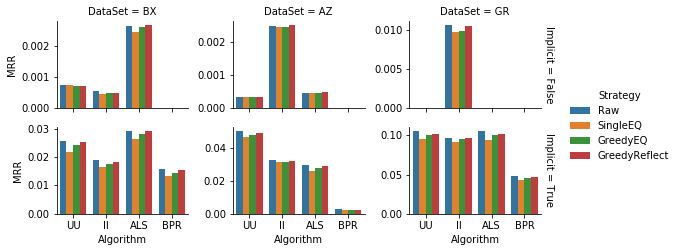

In [17]:
sns.catplot(x='Algorithm', y='MRR', row='Implicit', col='DataSet', hue='Strategy', data=rr_mrr, kind='bar',
            sharey=False, margin_titles=True, aspect=1.5, height=1.8)
plt.savefig('figures/rerank-perf.pdf')

In [18]:
penalty = (perf_data.set_index(['DataSet', 'Implicit', 'Algorithm']).MRR - \
   rerank_data.set_index(['DataSet', 'Implicit', 'Algorithm', 'Strategy']).MRR) / perf_data.set_index(['DataSet', 'Implicit', 'Algorithm']).MRR

In [19]:
print(penalty.unstack().to_latex(float_format=lambda f: '{:.2f}%'.format(f*100)))

\begin{tabular}{lllrrr}
\toprule
   &       & Strategy &  GreedyEQ &  GreedyReflect &  SingleEQ \\
DataSet & Implicit & Algorithm &           &                &           \\
\midrule
AZ & False & ALS &     0.39\% &         -0.89\% &     1.07\% \\
   &       & II &     1.26\% &         -0.35\% &     1.32\% \\
   &       & UU &     0.00\% &          0.00\% &     0.00\% \\
   & True  & ALS &     7.52\% &          2.25\% &    13.01\% \\
   &       & BPR &     6.71\% &          1.14\% &     7.46\% \\
   &       & II &     2.92\% &          1.05\% &     4.37\% \\
   &       & UU &     4.71\% &          1.96\% &     7.74\% \\
BX & False & ALS &     1.14\% &         -0.94\% &     7.09\% \\
   &       & II &    11.63\% &         10.14\% &    15.58\% \\
   &       & UU &     6.01\% &          6.09\% &     3.73\% \\
   & True  & ALS &     3.84\% &          0.45\% &    10.02\% \\
   &       & BPR &     7.95\% &          1.28\% &    14.40\% \\
   &       & II &     7.77\% &          4.19\% &    14.